# CHALLENGE DATA ENEDIS
Challenge context

About Enedis

ENEDIS is the main distribution system operator in France (95% of continental France, 36 million customers).

The electricity market requires that production and consumption be assigned to an upstream-downstream balance operator, each electricity provider having at least one. These balance operators guarantee that supply and demand are balanced every half-hour 24/7.

In order to assign energy, Enedis computes the electricity consumption balance every week for each balance operator. Part of the balancing computation involves some consumption or production modelling for several groups of customers (aka profiles). Since July 1st 2018, we started using “dynamic” profiles in this process, computed with measured energy. These dynamic profiles bring additional precision but can only be calculated ex-post.

Being able to forecast these values is very important since:

    They would bring robustness to our process.

    Energy planning is of utmost importance to balance operators, who have to guarantee energy supply beforehand and are held responsible for any unbalance in their portfolio.

Challenge goals

We would like to forecast 7 dynamic profile time-series, modelling the consumption shape of several mass-market customer groups (residential and small businesses with subscribed power up to 36 kVA) thanks to meteorological and calendar data, as well as any other real time dataset potentially correlated with consumption patterns. Those profiles are coefficients (without units) for each half-hour in the dataset.

The dataset size depends on each specific profile (collected from Oct 13th, 2013 onwards for residential profiles and from Nov 1st, 2016 for commercial profiles). This challenge is about forecasting dynamic profiles values from their past values and all the components of Enedis’ Half hourly Electrical Balancing.

The Testing period will be in the past, from July 1st, 2017 to June 30th, 2018.

There are many possible explanatory variables since consumption patterns are linked to consumers’ behavior and economic activity. Weather conditions (cold spell / heat wave) and business holidays will impact energy consumption but some other factors may also contribute to modifying energy consumption. As an example, our RES1 profile is presented there, over a week period:
In green: static series including business holidays. In blue: static series including business holidays and weather. In red: dynamic series computed ex-post.

Presentation of the challenge at the Collège de France

You can find the presentation of the challenge made at the Collège de France here (video in French)
Data description

Edit - 2019/03/22

Please be careful to the temporal alignment: For the same ID, there is a one day delay between data provided in the input files (that are measured or estimated for the date given in Horodate_UTC ) and the values of dynamic Profiles provided in the output files (representing customer behaviour for the date given in horodate). This delay allows to have a challenge closer to our operational needs: we will be able to get the data from the input files of the previous day to forecast the dynamic profiles.

Data in the time series are hour beginning: for example, a value at à 08h00 is the integrated value from 08h00 to 08h30 for the said data.
Training files include data for the period [13/10/2013 - 12/10/2018] excluding the [01/07/2017 - 30/06/2018] period.
Regarding the 3 commercial profiles, data only start on Nov 1st,2016.
Testing files include data for the [01/07/2017 - 30/06/2018] period.
Please note that we use the French date and time notation: dd/mm/YYYY HH:MM in the files.
Time series description for the input files
Weather data:

    Température réalisée lissée (°Celcius) Average recorded temperature (°C)
    Température normale lissée (°Celcius) Average standard temperature (°C)
    Pseudo rayonnement Pseudo radiation (Linear combination of recorded data from 32 official weather stations

Measured data

    Electricity exchange with other networks:
    Injection RTE (W) Average power (during the half hours) injected from RTE (transmission grid) (W)
    Refoulement RTE (W) Average power injected back into the transmission grid (W)

    Soutirage net vers autres GRD (W) Average power injected into local DSO networks (W)

    From Smart meters
    Consommation HTA télérelevée en courbe de charge (W) load curve-measured medium voltage (MV, i.e., 20 000 V in most areas) consumption (W)
    Production décentralisée télérelevée en courbe de charge (W) load curve-measured decentralized production (W)

Modelled Data:

    Pertes modélisées (W) Losses Model based on a second order polynomial, recalibrated every year. (Based on RTE gross injection until July 1st, 2018, and on net RTE injection (Power injected – Power injected back to transmission grid), net Power injected into local independent DSOs and decentralized production since that date.
    Consommation totale profilée (W) Total modelled consumption (W)
    Consommation HTA profilée (W) MV modelled consumption (W)
    Consommation PME-PMI profilée (W) SMEs and SMIs modelled consumption (W)
    Consommation professionnelle profilée (W) Small businesses modelled consumption (W)
    Consommation résidentielle profilée (W) Households modelled consumption (W)
    Production décentralisée profilée (W) Total modelled decentralized production (W)
    Production photovoltaïque profilée (W) Photovoltaic modelled production (W)
    Production autre profilée (W) Other modelled decentralized production (W) Modelling of customer consumption through static profiling until July 1st, 2018. Since then the modelling technique has changed for 7 consumption sub profiles, from static to dynamic modelling based on real measurements.

Sums (from Models and Measurements):

    Consommations totale (W) Total consumption (W)
    Production décentralisée totale (W) Total decentralized production (W)
    Production éolienne totale (W) Total wind production (W)
    Production photovoltaïque totale (W) Total Photovoltaic production (W)
    Consommation HTA totale (W) total MV consumption (W)

Time Series description for the Output Files

    RES1_BASE: Residential customer profile, subscribed power up to 6kVA, with no tariff option
    RES11_BASE: Residential customer profile, subscribed power over 6kVA, with no tariff option
    RES2_HP: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours.
    RES2_HC: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.
    PRO1_BASE: Commercial customer profile, with no tariff option
    PRO2_HP: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours
    PRO2_HC: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.


In [1]:
from dataviz import data_slice,data_timeplot,data_slice_year
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

In [2]:

X_train=pd.read_csv('training_input_qFI2jug.csv', index_col="Horodate_UTC")
feature_list=list(X_train.columns[3:])
#X_train['timestamp']=pd.to_datetime(X_train.index)
X_train.index = pd.DatetimeIndex(X_train.index)

liste_dates = X_train.index.tolist()
for dt in liste_dates :
    X_train.at[dt, 'sort'] = dt.strftime('%m%d%H%S')

X_train['sort'].astype(int)

df_month = X_train.sort_values(by='sort', ascending=True)
df_month.head(20)
df_month = df_month.interpolate(str="linear", axis=0).ffill().bfill()
df = df_month.sort_values(by='IDS', ascending=True)

X_train.drop('sort', axis=1)

X_train['Pseudo rayonnement'] = df['Pseudo rayonnement']
X_train['timestamp']=pd.to_datetime(X_train.index)




In [22]:
X_test=pd.read_csv('testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [4]:
y_train=pd.read_csv('training_output_uamzSZW.csv',index_col="Horodate_UTC")
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

In [5]:
X_train.head()

,IDS,Horodate,Mois,Injection RTE (W),Refoulement RTE (W),Pertes modélisées (W),Consommations totale (W),Consommation HTA télérelevée à courbe de charge (W),Consommation totale profilée (W),Consommation HTA profilée (W),...,Production autre profilée (W),Température réalisée lissée (°Celcius),Température normale lissée (°Celcius),Production éolienne totale (W),Production photovoltaïque totale (W),Pseudo rayonnement,Consommation HTA totale (W),Soutirage net vers autres GRD (W),sort,timestamp
Horodate_UTC,,,,,,,,,,,,,,,,,,,,,
2013-10-13 22:00:00,1,2013-10-13T00:00:00+02:00,10,39784230000,103415000,2849582877,37576289504,8062590100,29513699404,1009515939,...,608873.0,9.6,13.5,302936853.0,19660.0,68.988889,9072106039,436423300,10132200,2013-10-13 22:00:00
2013-10-13 22:30:00,2,2013-10-13T00:30:00+02:00,10,37114681000,119543000,2603906116,35230706411,8023402840,27207303571,1007708541,...,608873.0,9.6,13.5,368725682.0,17004.0,68.977778,9031111381,407924660,10132200,2013-10-13 22:30:00
2013-10-13 23:00:00,3,2013-10-13T01:00:00+02:00,10,36148675000,136447000,2516689035,34428316838,7982839990,26445476848,966660739,...,608873.0,9.6,13.5,448572685.0,24299.0,68.877778,8949500729,398239990,10132300,2013-10-13 23:00:00
2013-10-13 23:30:00,4,2013-10-13T01:30:00+02:00,10,35488831000,164083000,2457628530,33922151279,7953531370,25968619909,929311479,...,608873.0,9.5,13.5,550243295.0,23308.0,68.822222,8882842849,380571680,10132300,2013-10-13 23:30:00
2013-10-14 00:00:00,5,2013-10-13T02:00:00+02:00,10,34882911000,191859000,2403762298,33447730318,7922448360,25525281958,907509517,...,608873.0,9.5,13.5,644783673.0,21963.0,68.755556,8829957877,367153030,10140000,2013-10-14 00:00:00


In [15]:
X_train.index

DatetimeIndex(['2013-10-13 22:00:00', '2013-10-13 22:30:00',
               '2013-10-13 23:00:00', '2013-10-13 23:30:00',
               '2013-10-14 00:00:00', '2013-10-14 00:30:00',
               '2013-10-14 01:00:00', '2013-10-14 01:30:00',
               '2013-10-14 02:00:00', '2013-10-14 02:30:00',
               ...
               '2018-10-13 17:00:00', '2018-10-13 17:30:00',
               '2018-10-13 18:00:00', '2018-10-13 18:30:00',
               '2018-10-13 19:00:00', '2018-10-13 19:30:00',
               '2018-10-13 20:00:00', '2018-10-13 20:30:00',
               '2018-10-13 21:00:00', '2018-10-13 21:30:00'],
              dtype='datetime64[ns]', name='Horodate_UTC', length=70128, freq=None)

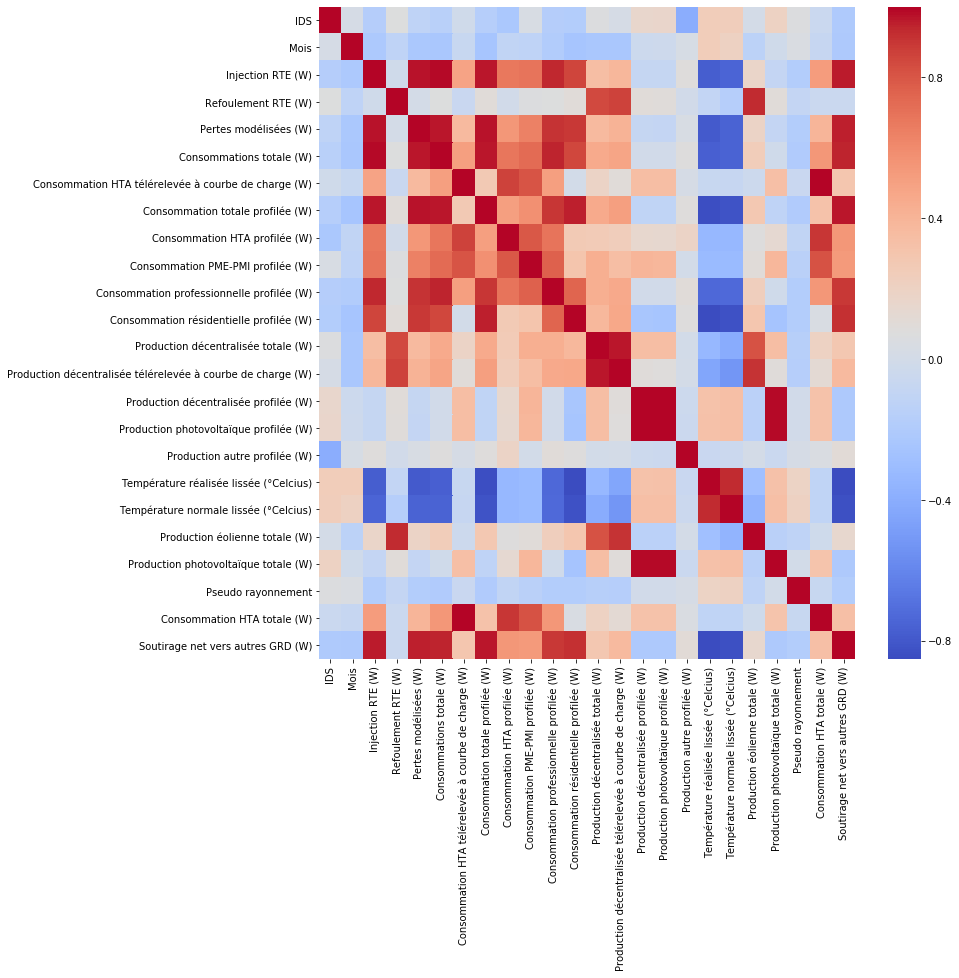

In [6]:
# visualisation pour se donner une idée de la corrélation des features
corr=X_train.corr()
fig,ax=plt.subplots(figsize=(12,12))
sns.heatmap(corr,ax=ax,cmap='coolwarm')
plt.show()

# Analyses des séries temporelles

# Snapchot données entrainement X_train sur une journée

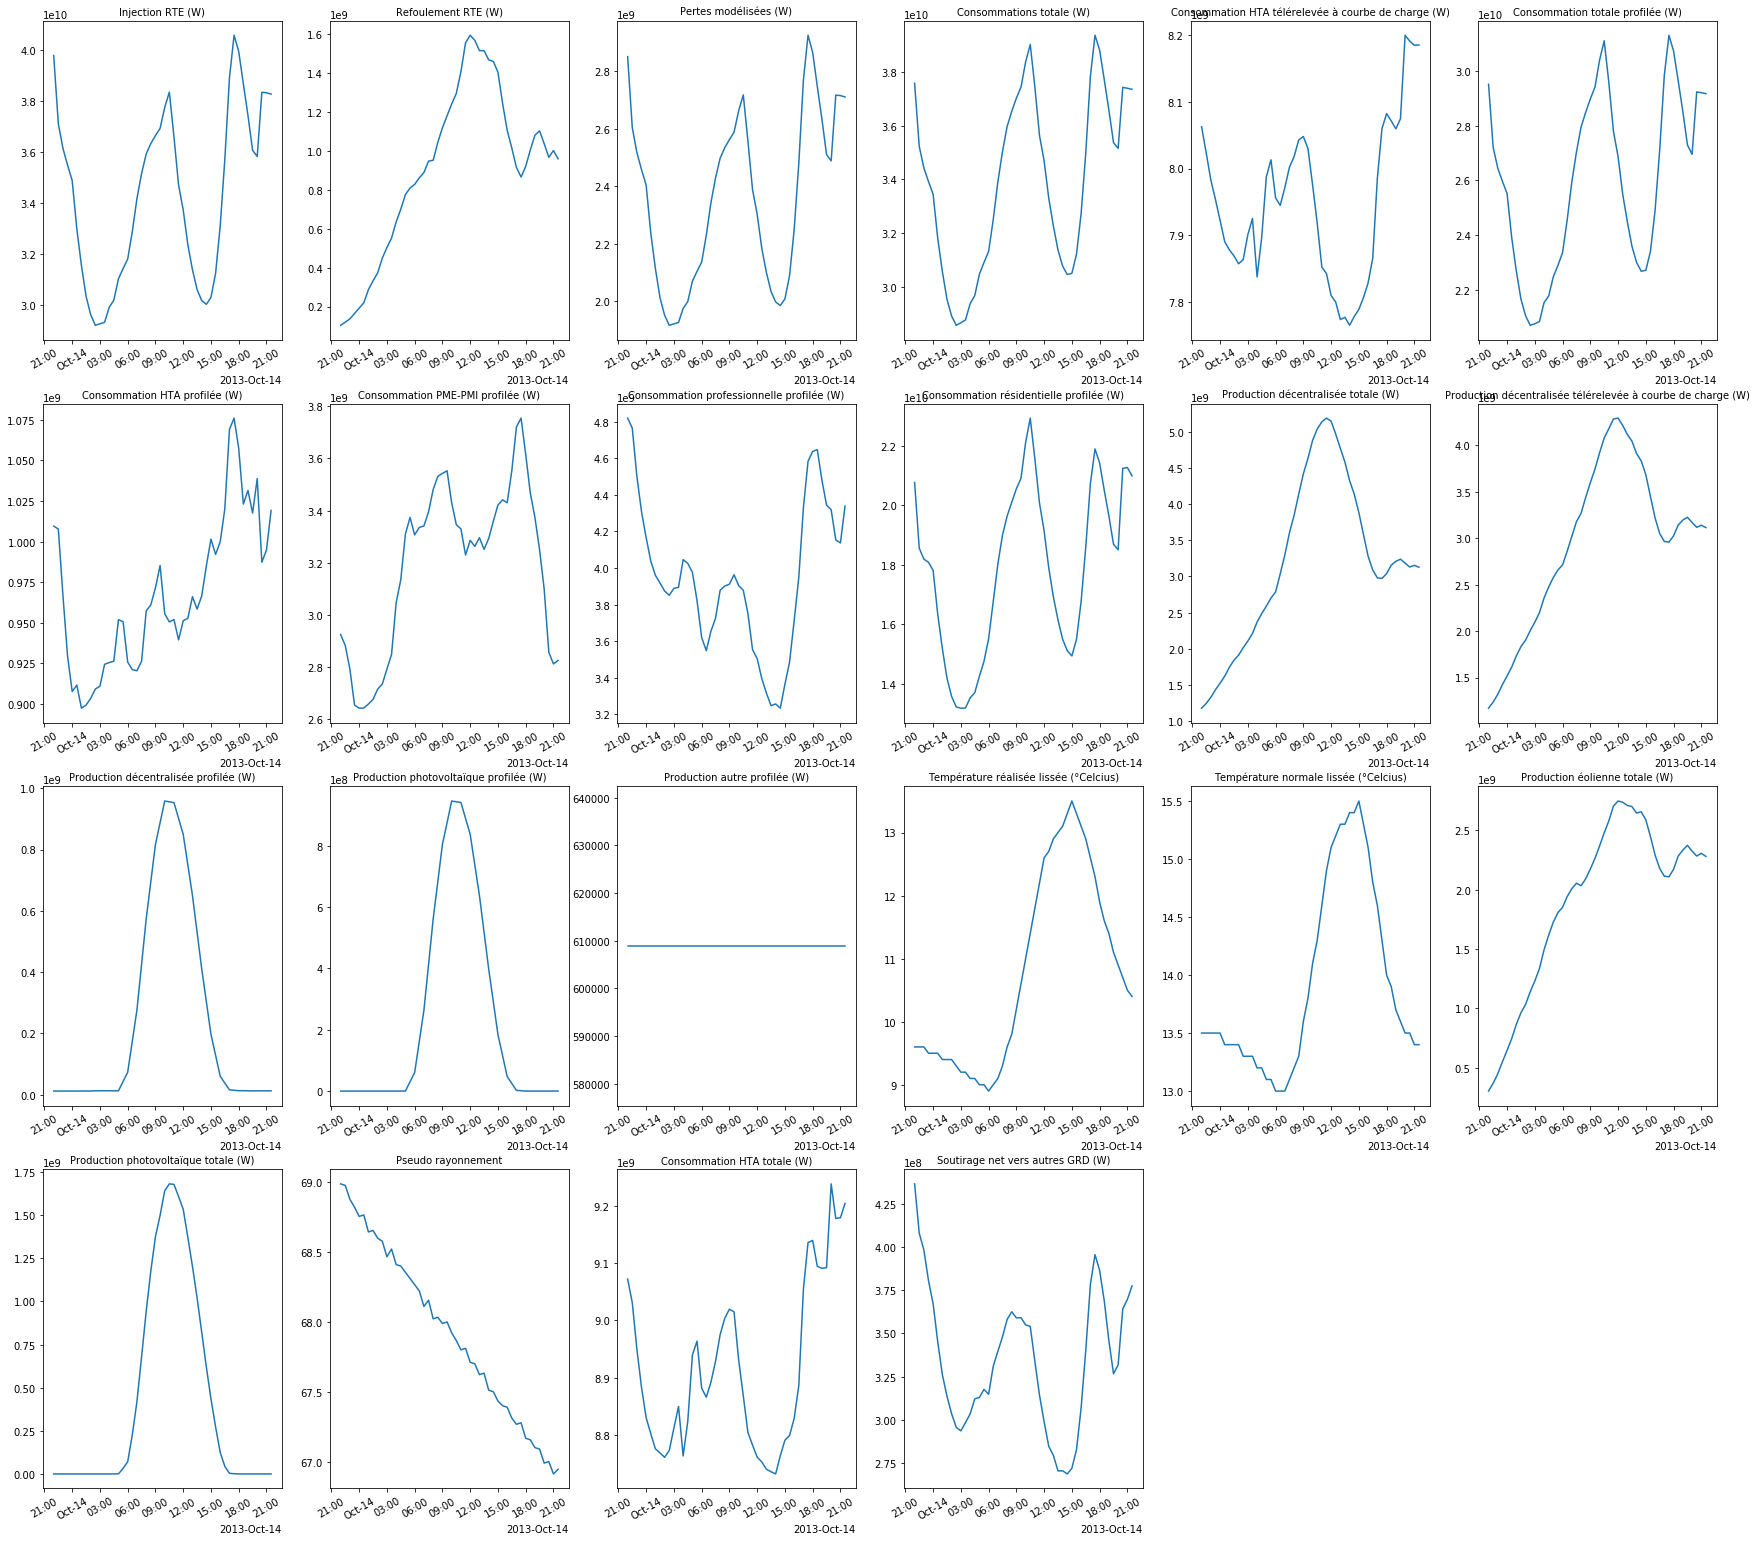

In [7]:
from dataviz import data_slice,data_timeplot

df_slice=data_slice(X_train,0,1,feature_list)
data_timeplot(df_slice,6)


# Visualisation profile RES1_BASE

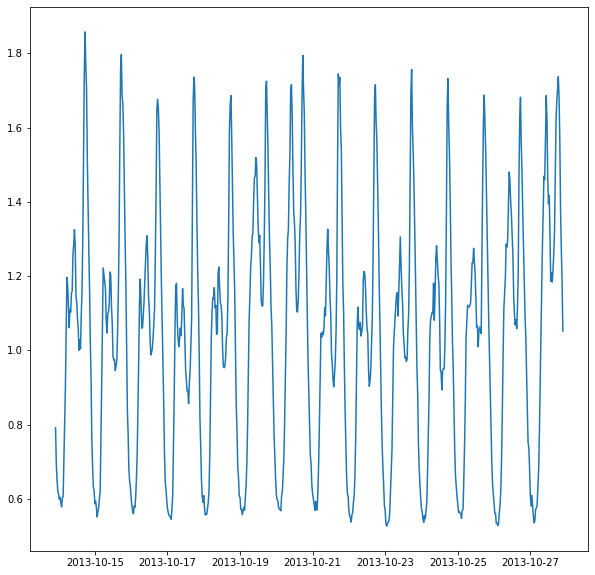

In [8]:
y_slice=data_slice(y_train,0,14,columns=['RES1_BASE'])
plt.figure(figsize=(10,10))
plt.plot(y_slice)

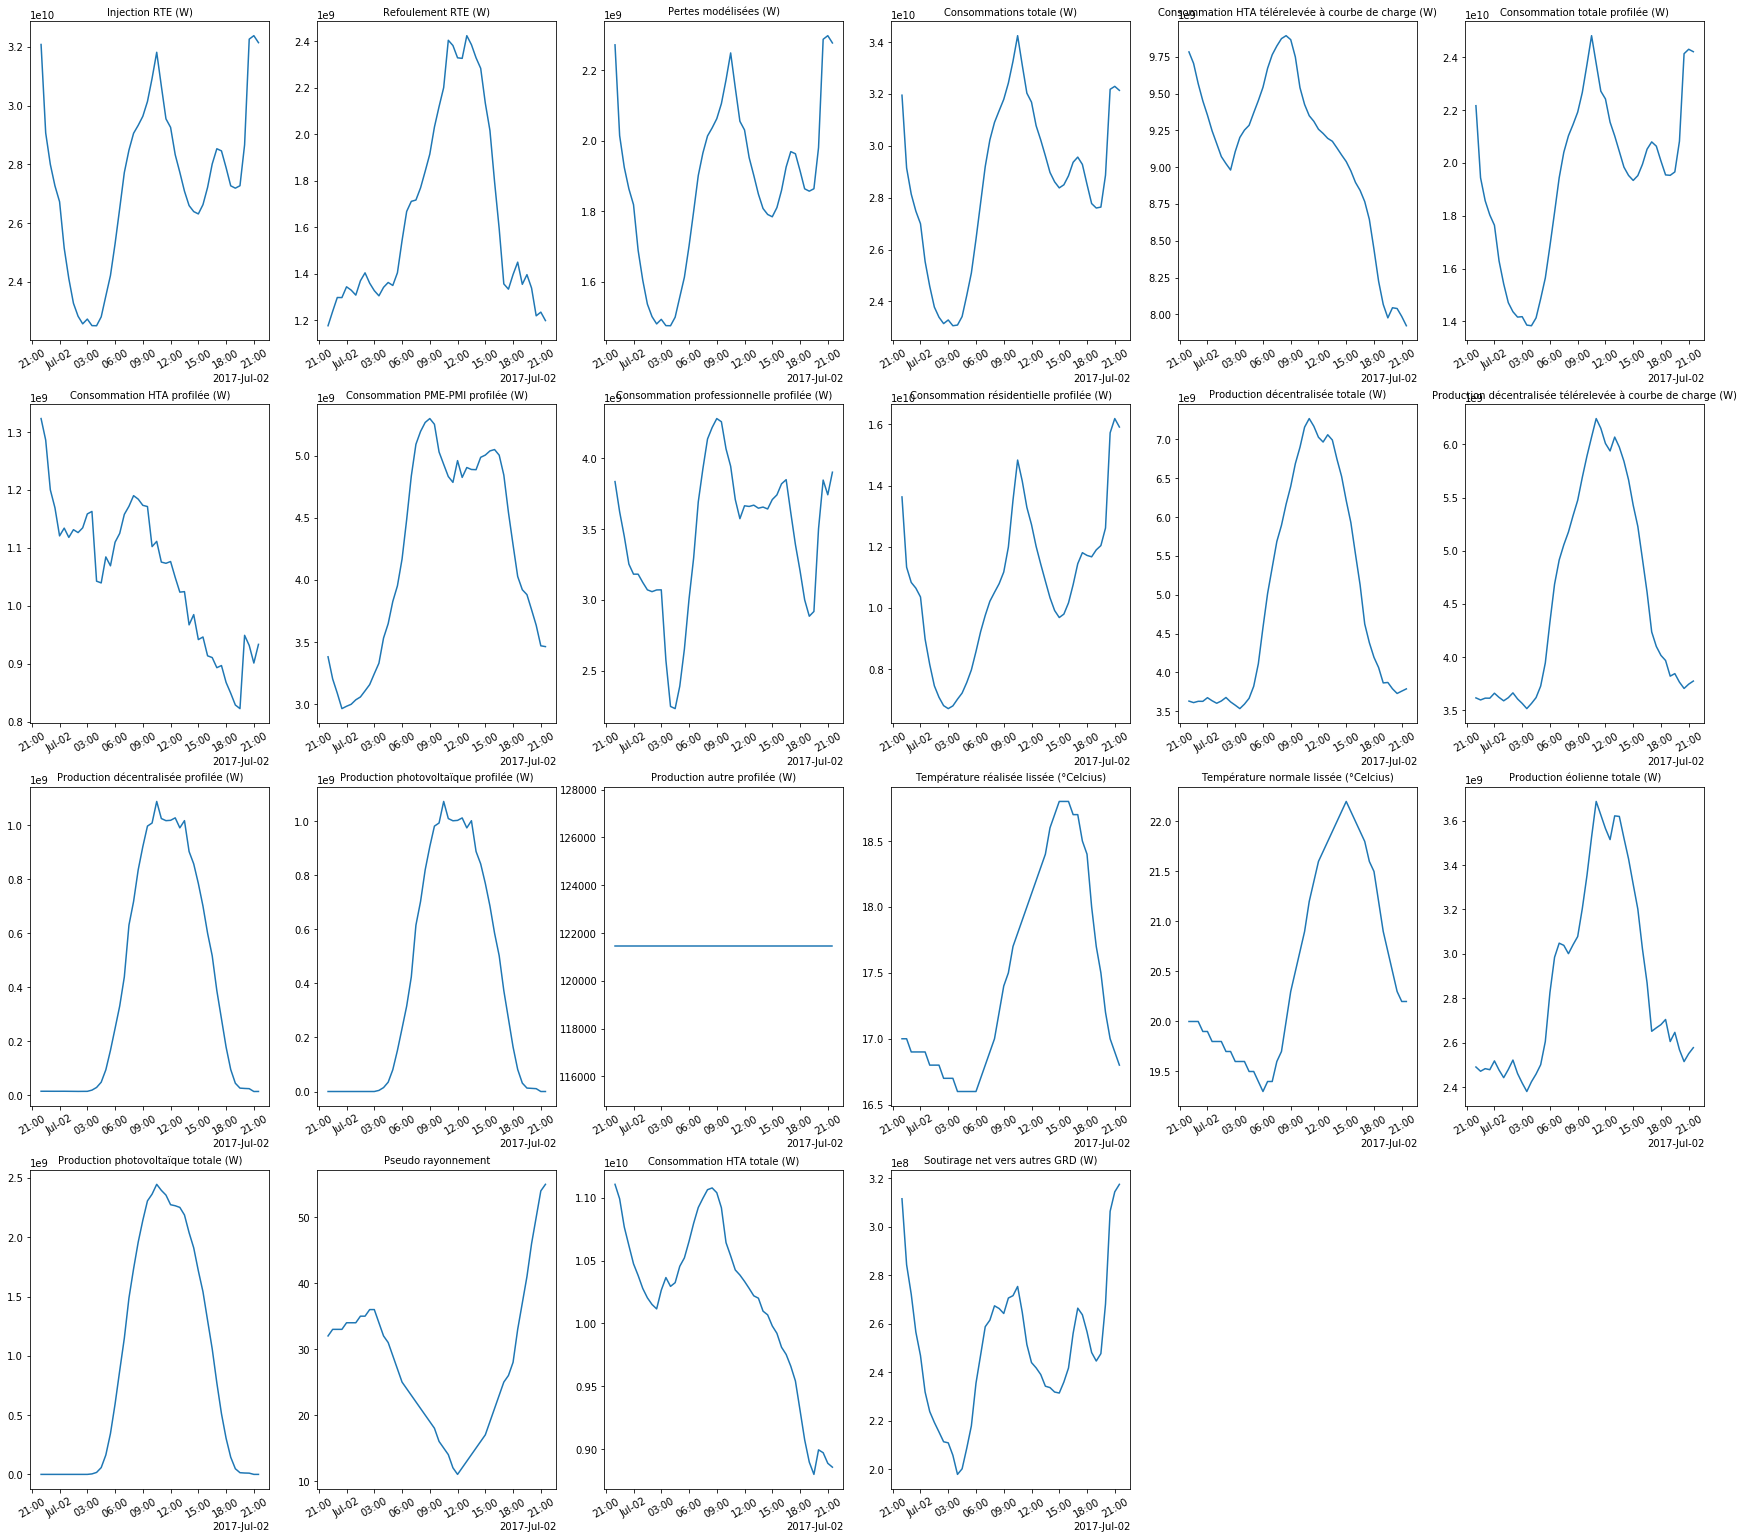

In [23]:
from dataviz import data_slice,data_timeplot

df_slice=data_slice(X_test,0,1,feature_list)
data_timeplot(df_slice,6)

In [25]:
X_daily=X_train.resample('D').sum()
X_weekly=X_train.resample('W').sum()

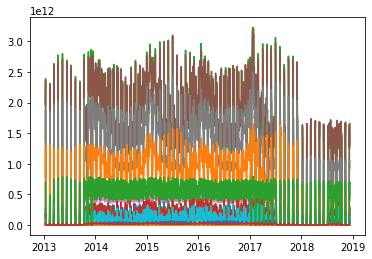

In [26]:
plt.plot(X_daily);


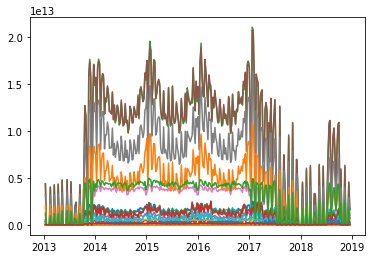

In [27]:
plt.plot(X_weekly);

## Computation of pivot-table 

this will be usefull for the profile clustering

Creation of two new columns hour (hour of the day) and day (day of the year)
Computation of the pivot-table for the feature 'Consommation professionnelle profilée (W)'
The new dataframe reflects the distribution of daily profile over the DataFrame timespan
The example shows distribution over 2014 year

In [37]:
X_train['hour']=X_train['timestamp'].dt.time
X_train['day']=X_train['timestamp'].dt.dayofyear
temp=data_slice_year(X_train,2014)
temp_all_days=temp.pivot_table(index=['hour'],columns=['day'],values=['Consommation professionnelle profilée (W)'],fill_value=0)
temp_all_days.head()

Consommation professionnelle profilée (W)                          \
day                                            1           2           3     
hour                                                                         
00:00:00                                5970614724  6216473936  5750499418   
00:30:00                                5874966952  6157917319  5636640837   
01:00:00                                5763898055  6036074425  5503205126   
01:30:00                                5750440208  5965851716  5472928188   
02:00:00                                5760885449  5918062665  5452068454   

                                                                      \
day              4           5           6           7           8     
hour                                                                   
00:00:00  4160131575  3898496644  3617313753  3314041310  3397759886   
00:30:00  4180729058  3898674958  3609575553  3374317837  3377447909   
01:00:00  4166866373  3869339713  3518574163  3274752307  3283316472   
01:30:00  4144979431  3808458160  3414611918  3194645190  3269486697   
02:00:00  4176891737  3748250595  3369122717  3171714986  3197674405   

                                  ...                                      \
day              9           10   ...         356         357         358   
hour                              ...                                       
00:00:00  3495006682  3194886125  ...  5237475267  5257133023  5369923416   
00:30:00  3429926638  3138865012  ...  5136045210  5145343225  5272331298   
01:00:00  3387189527  3092315775  ...  4984334596  4999740078  5168834599   
01:30:00  3339897899  3068568339  ...  4956794499  5009222719  5178495331   
02:00:00  3296381110  3069101589  ...  4999477950  5029128414  5215362274   

                                                                      \
day              359         360         361         362         363   
hour                                                                   
00:00:00  5560864437  5717061890  5616895122  5670720606  6070208153   
00:30:00  5458015080  5623689790  5537006355  5581535374  5998841824   
01:00:00  5335046712  5459720758  5420768448  5453410824  5863121636   
01:30:00  5272933741  5388855262  5373592496  5382878391  5812031693   
02:00:00  5288843918  5358655427  5381576571  5382514638  5827387640   

                                  
day              364         365  
hour                              
00:00:00  6868488975  6820892138  
00:30:00  6775620049           0  
01:00:00  6646447996           0  
01:30:00  6632863162           0  
02:00:00  6596099075           0  

[5 rows x 365 columns]

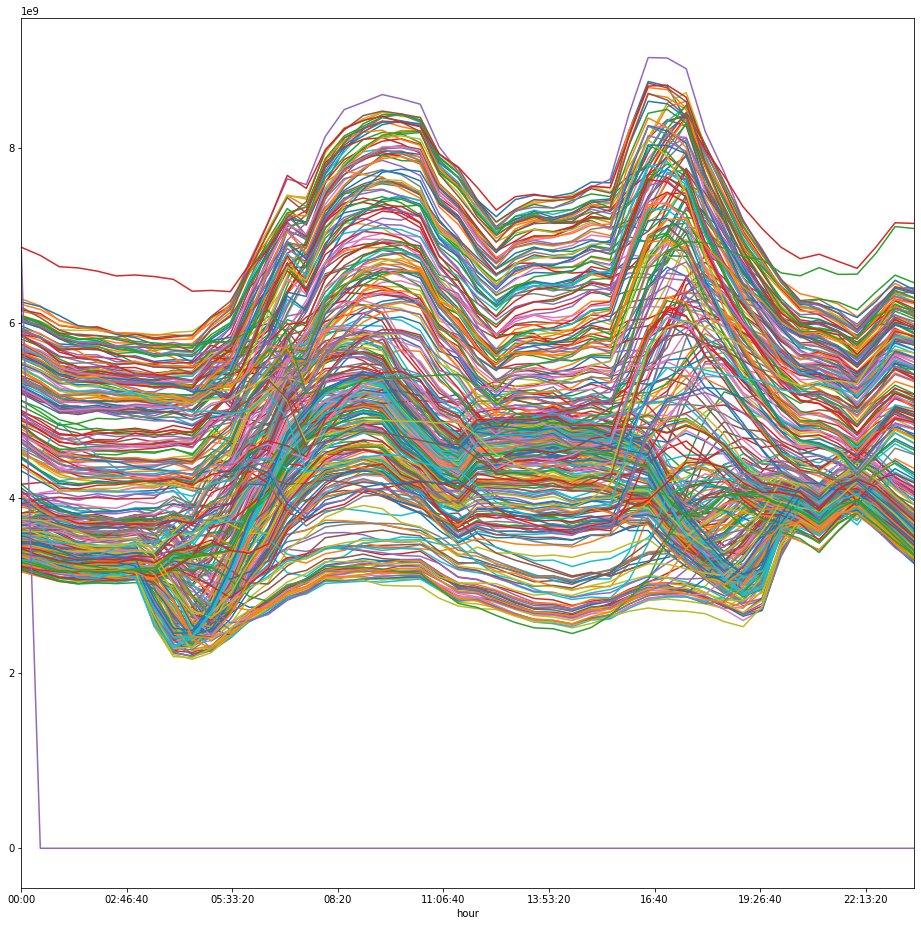

In [29]:
temp_all_days.plot(figsize=(16,16),legend=False)

## Computation of pivot-table after splitting between business and non business days

Show the profiles distribution after split

In [40]:
from jours import holydays

calendar = holydays()

calendar.Dataframe(temp)

# calendar.split()



In [41]:
temp_business_days=calendar.business_days()
temp_public_holiday=calendar.public_holiday()


In [ ]:
temp_business_days=temp_business_days.pivot_table(index=['hour'],columns=['day'],values=['Consommation professionnelle profilée (W)'],fill_value=0)
temp_public_holiday=temp_public_holiday.pivot_table(index=['hour'],columns=['day'],values=['Consommation professionnelle profilée (W)'],fill_value=0)


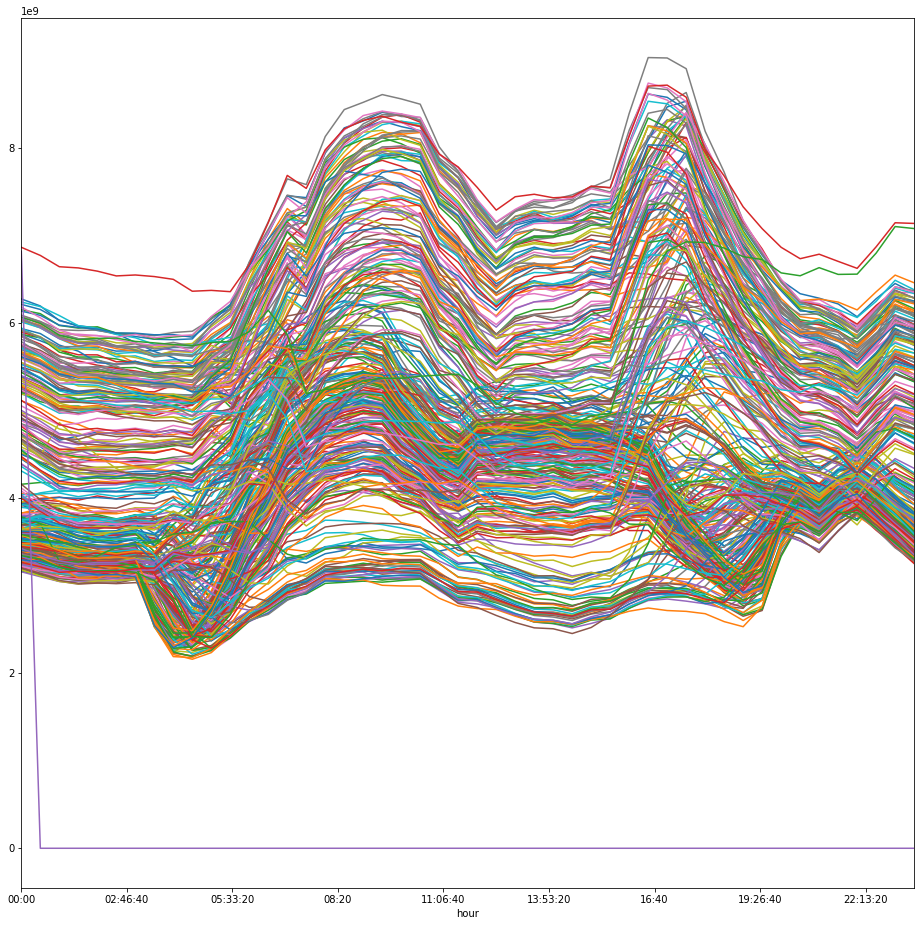

In [32]:
temp_business_days.plot(figsize=(16,16),legend=False)

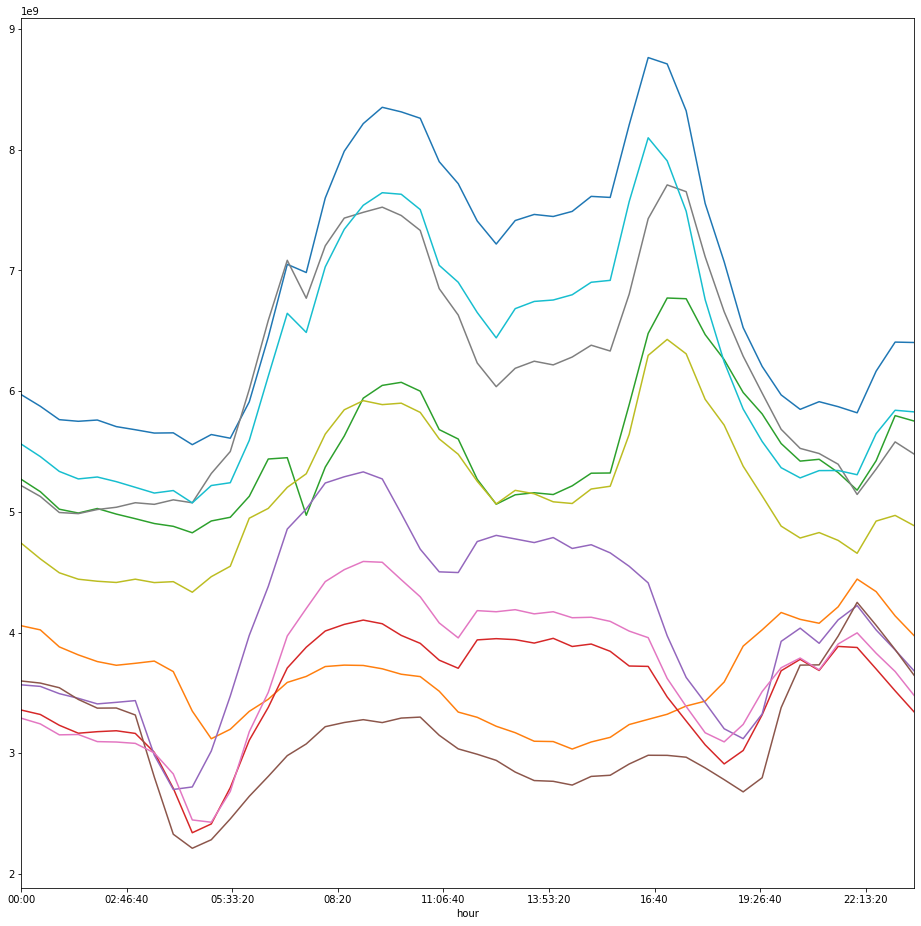

In [33]:
temp_public_holiday.plot(figsize=(16,16),legend=False)

seems that there is an issues as only 10 profiles have been plotted. We shall have at minimum more than 102 profiles (number of 2 * nb week)